In [1]:
import sys; sys.path.append('..'); from wwa import *
mapproj = cartopy.crs.PlateCarree()

from warnings import filterwarnings
filterwarnings("ignore", category = UserWarning)

Xn, Xx, Yn, Yx = [-85,-75,5,15]
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7]    # resized to focus more closely on Gatun catchment

region = "Lake Gatun region (lon "+str(xn)+":"+str(xx)+", lat "+str(yn)+":"+str(yx)+")"

units = {"pr" : "mm/day", "tasmin" : "degC", "tasmax" : "degC"}

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))
sf = sf.loc[sf.ORDER == 1]

/home/cb2714/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [2]:
from taylorDiagram import TaylorDiagram, taylor_scores

# plotting parameters
gcm_markers = {'CNRM-CM5_r1i1p1': 'o',
                 'CSIRO-Mk3-6-0_r1i1p1': 'H',
                 'CanESM2_r1i1p1': 'd',
                 'EC-EARTH_r12i1p1': 'p',
                 'GFDL-ESM2M_r1i1p1': '<',
                 'HadGEM2-ES_r1i1p1': 'P',
                 'HadGEM2-ES_r2i1p1': 'P',
                 'IPSL-CM5A-MR_r1i1p1': 's',
                 'MIROC5_r1i1p1': '>',
                 'MPI-ESM-LR_r1i1p1': '^',
                 'MPI-ESM-MR_r1i1p1': 'v',
                 'NorESM1-M_r1i1p1': 'X',}

rcm_colours = {'CRCM5'    : 'gold',
               'RCA4'     : 'violet',
               'REMO2009' : 'olivedrab',
               'REMO2015' : 'green',
               'RegCM4-3' : 'turquoise',
               'RegCM4-7' : 'blue',
               'WRF341I'  : 'red',}

gcm_handles = [matplotlib.lines.Line2D([], [], color = "w", marker = m, markersize = 6, markeredgecolor = "black", linestyle = "None") for gcm_nm, m in gcm_markers.items()]
rcm_handles = [matplotlib.lines.Line2D([], [], color = c, marker = 'o', markersize = 6, markeredgecolor = "black", linestyle = "None") for rcm_nm, c in rcm_colours.items()]

# Seasonal cycle of precip

In [139]:
chirps = xr.open_dataset("data/pr_monthly_chirps-catchment.nc").pr.groupby("time.month").mean()

domain = "SAM"
fl = sorted(glob.glob("cordex/ts/*"+domain+"*catchment.nc"))

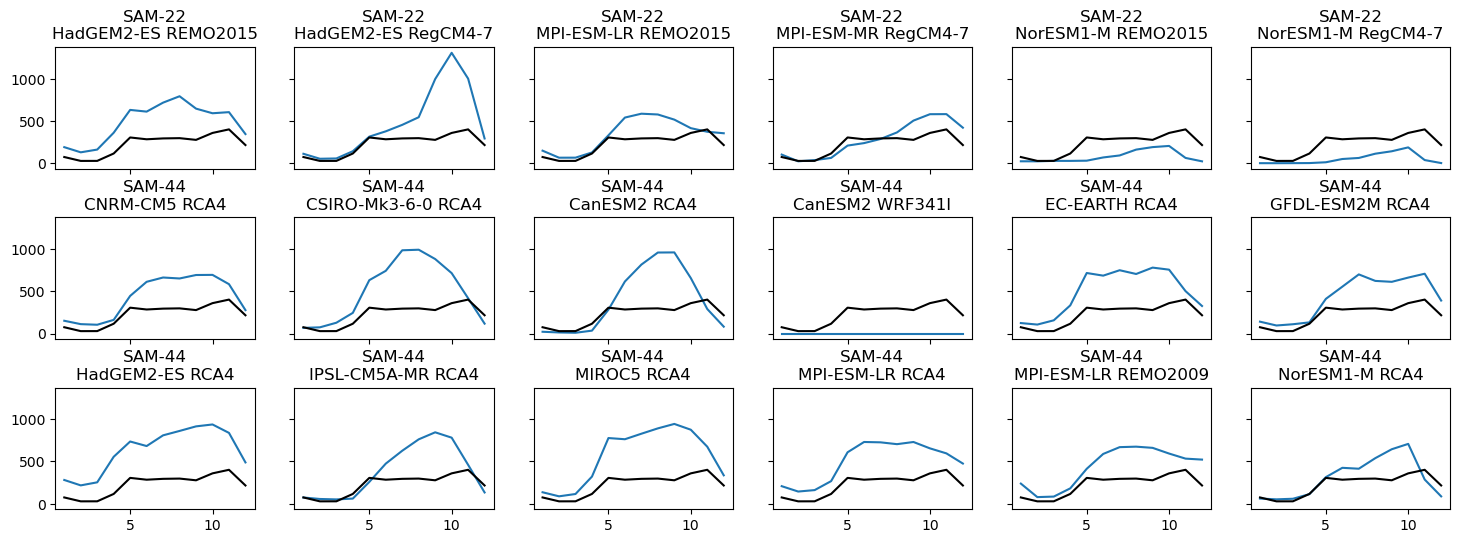

In [140]:
fig, axs = plt.subplots(ncols = int(len(fl)/3), nrows = 3, figsize = (len(fl),6), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.4)

for i in range(len(fl)):
    ax = fig.axes[i]
    fnm = fl[i]
    mdl = fnm.split("_")[1]+"\n"+re.sub("r[0-9]+i1p1 ",""," ".join(fnm.split("_")[2:5]))
    
    ds = xr.open_dataset(fnm).pr.sel(time = slice("1981", "2023"))
    sc = ds.resample(time = "MS").sum().groupby("time.month").mean()
    
    sc.plot(ax = ax)
    chirps.plot(ax = ax, color = "k")
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax.set_title(mdl)
                        
for i in range(len(fl), len(fig.axes)): axs[i].set_axis_off()
    
plt.savefig("fig/seasonal-cycle_pr_cordex-"+domain+"_sc-plots.png")

## Taylor diagram

In [147]:
cordex = []

for i in range(len(fl)):
    fnm = fl[i]
    mdl = "_".join(fnm.split("_")[1:5])
    
    cordex.append(xr.open_dataset(fnm).pr.sel(time = slice("1981", "2023")).resample(time = "MS").sum().groupby("time.month").mean().expand_dims(run = [mdl]))

cordex = xr.concat(cordex, "run")

In [148]:
# check that all RCMs are in the list
set([r.split("_")[-1] for r in cordex.run.values])

{'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-7', 'WRF341I'}

In [149]:
corrs, sds, ref_sd = taylor_scores(cordex, chirps)
max_sd = max(np.ceil(max(sds) / ref_sd), 1.1)
min_corr = min(corrs)

In [150]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : cordex.run.values, "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[:, "eval"] = "bad"
td_df.loc[(td_df.cor >= 0.8) | ((td_df.sd <= 2*ref_sd) & (td_df.sd >= 0.5*ref_sd)), "eval"] = "reasonable"
td_df.loc[(td_df.cor >= 0.8) & (td_df.sd <= 2*ref_sd) & (td_df.sd >= 0.5*ref_sd), "eval"] = "good"

td_df.sort_index().to_csv("res/seasonal-cycle_pr_cordex-"+domain+"_taylor-scores.csv")

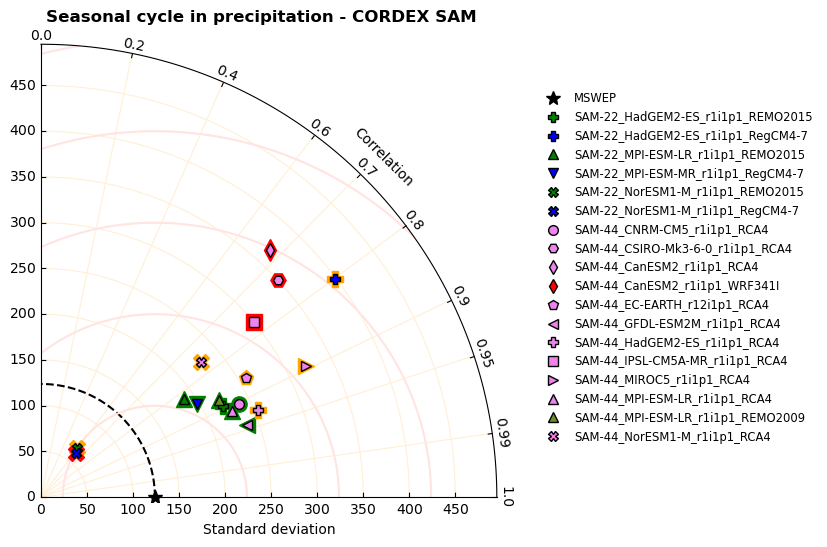

In [154]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[1:3])]
    rcm_colour = rcm_colours[mdl.split("_")[-1]]
    
    # change border width depending on model resolution
    mew = 1
    if mdl.split("_")[0][-2:] == "22": mew = 1
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "k", label = mdl, mew = mew, zorder = 9)
    
    # highlight category each falls into
    bg_col = {"good" : "green", "reasonable" : "orange", "bad" : "red"}[td_df.loc[mdl,"eval"]]
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 11, ls = '', mfc = bg_col, mec = bg_col, label = "_", zorder = 8)

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation - CORDEX "+domain, fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/seasonal-cycle_pr_cordex-"+domain+"_taylor-diagram.png")

# Spatial pattern of rs precip

In [9]:
Xn, Xx, Yn, Yx = [xn-2,xx+2,yn-2,yx+2]

chirps = xr.open_dataset("data/chirps_panama_monthly.nc").sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).pr.rolling(time = 8).sum().sel(time = slice("1990","2020")).groupby("time.month")[12].mean("time")
chirps.plot(cmap = "YlGnBu", subplot_kws = {"projection" : mapproj})
ax = plt.gca()
ax.coastlines()
sf.boundary.plot(ax = ax, color = "darkred")

In [6]:
domain = "CAM"
fl = sorted(glob.glob("cordex/sp/*"+domain+"*.nc"))

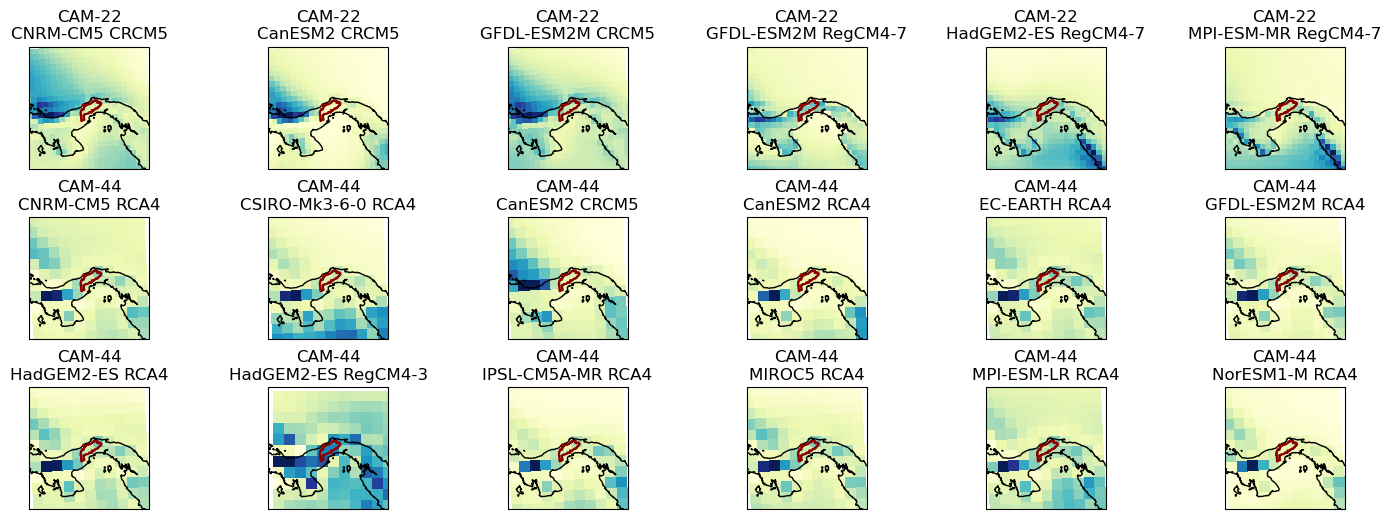

In [7]:
fig, axs = plt.subplots(ncols = int(len(fl)/3), nrows = 3, figsize = (len(fl),6), dpi = 100, sharey = True, sharex = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : [Xn,Xx,Yn,Yx]})
plt.subplots_adjust(hspace = 0.4)

for i in range(len(fl)):
    ax = fig.axes[i]
    fnm = fl[i]
    mdl = re.sub("-spatial.nc","",fnm.split("_")[1]+"\n"+re.sub("r[0-9]+i1p1 ",""," ".join(fnm.split("_")[2:5])))
    
    ds = xr.open_dataset(fnm).sel(season = "wet").pr
    
    if not "lon" in ds.coords: continue
    
    if "rlon" in ds.dims:
        xdim,ydim = ["rlon", "rlat"]
    else:
        xdim,ydim = ["x","y"]
    
    rm = np.logical_and(np.logical_and(ds.lon >= Xn, ds.lon <= Xx), np.logical_and(ds.lat >= Yn, ds.lat <= Yx))
    rm = rm.where(rm == 1).dropna(xdim, "all").dropna(ydim,"all")
    ds = ds.sel({xdim : rm[xdim], ydim : rm[ydim]})
    ax.pcolormesh(ds.lon, ds.lat, ds, cmap = "YlGnBu")
    ax.coastlines()
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax.set_title(mdl)
    sf.boundary.plot(ax = ax, color = "darkred")
                        
plt.savefig("fig/spatial-pattern_pr_cordex-"+domain+"_spatial-maps.png")